##### Copyright 2020 The TensorFlow Constrained Optimization Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the \"License\"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an \"AS IS\" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# TensorFlow Constrained Optimization Example Using CelebA Dataset
Building on other [TensorFlow Constrained Optimization (TFCO)](https://github.com/google-research/tensorflow_constrained_optimization/tree/master/README.md) examples, the purpose of this notebook is to further demonstrate how easy it is to create and optimized constrained problems using the TFCO library. In particular, this notebook will:


*   Train a simple, *unconstrained* neural network model to detect a person's smile in images using [`tf.keras`](https://www.tensorflow.org/guide/keras) and the large-scale CelebFaces Attributes ([CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)) dataset.
*   Evaluate model performance across age group.
*   Set up a simple constrained optimization problem to achieve fairer perforamnce across age group.
*   Retrain the now *constrained* model and evaluate performance again.

Last updated: 15 Sep 2020





# Installation
This notebook was created in [Colaboratory](https://research.google.com/colaboratory/faq.html), connected to the Python 3 Google Compute Engine backend. If you wish to host this notebook in a different environment, then you should not experience any major issues so long as you include all the required packages listed in the cell below.

Also, depending on when you run the cell below, you may receive a warning about the default version of TensorFlow in Colab switching to TensorFlow 2.X soon. You can safely ignore that warning as this notebook was designed to be compatible with TensorFlow 1.X and 2.X.

In [ ]:
#@title Import Modules
!pip install -q tensorflow-datasets tensorflow numpy pandas matplotlib seaborn
import os
import sys
import tempfile
import urllib3

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Use the GitHub version of TFCO
!pip install git+https://github.com/google-research/tensorflow_constrained_optimization
import tensorflow_constrained_optimization as tfco

Though TFCO is compatible with eager and graph execution, this notebook assumes that eager execution is enabled by default. To ensure that nothing breaks, eager execution will be enabled in the cell below.

In [ ]:
#@title Enable Eager Execution
if tf.__version__ < "2.0.0":
  tf.enable_eager_execution()
  print("Eager execution enabled.")
else:
  print("Eager execution enabled by default.")

print("TensorFlow " + tf.__version__)

Eager execution enabled by default.
TensorFlow 2.3.0


# CelebA Dataset
[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200,000 celebrity images, each with 40 attribute annotations (such as hair type, fashion accessories, facial features, etc.) and 5 landmark locations (eyes, mouth and nose positions). CelebA is readily made available in TensorFlow thanks to [TensorFlow Datasets(`tfds`)](https://www.tensorflow.org/datasets), which is where and how this notebook will download and extract the dataset.

Specifically, in this notebook:
*   The "Smiling" attribute — which presumably represents a pleased, kind or amused expression in the image with the corners of the mouth turned up and front teeth possibly exposed — will be set as the target variable for the model to predict.
*   Images will be resized from 218x178 to 28x28 to reduce the amount of execution time and memory when training.
*   Performance will be evaluated across the "Young" attribute, which will be dubbed "age group" in this notebook.




### Possible Checksum Error
On rare occasions, running the cell below may return a `NonMatchingChecksumError` message. As [reported elsewhere](https://github.com/tensorflow/datasets/issues/943), this error message might be due to an incomplete download. CelebA is rather large and can sometimes fail to download. So this may be a Google Drive issue rather than TFDS.

In our experiences, running the cell again at a later point in time will resolve that error and allow you to download the dataset.

In [ ]:
celeb_a_builder = tfds.builder("celeb_a")
celeb_a_builder.download_and_prepare()

## Caveats
Before moving forward, there are several considerations to keep in mind in using CelebA:
*   Though in principle this notebook could use any dataset of face images, CelebA was chosen because it contains public domain images of public figures, which avoids certain policy and privacy issues of some other public domain datasets.
*   All of the attribute annotations in CelebA come operationalized as binary categories. For example, the "Young" attribute, which loosely and presumably represents perceived behavior or appearance of young people, is denoted as either present or absent in the image. In other words, the absence of "Young" in an image does not always imply that the image features an "Old" celebrity.
*   CelebA's categorizations do not reflect real human diversity of attributes.
*   For the purposes of this notebook, the "Young" attribute is dubbed "age group", where the presence of the "Young" attribute in an image is labeled as a member of the "young" age group and the absence of the "Young" attribute is labeled as a member of the "old" age group. These are assumptions made as this information is not mentioned in the [original paper](http://openaccess.thecvf.com/content_iccv_2015/html/Liu_Deep_Learning_Face_ICCV_2015_paper.html).
*   As such, performance in the models trained in this notebook is tied to the ways the attributes have been operationalized and annotated by the authors of CelebA.
*   This model should not be used for commerical purposes as that would voilate CelebA's non-commerical research agreement.

# Setting Up Input and Visualization Functions
Now that CelebA is loaded in as a `tf.data.Dataset` object, the rest of the input pipeline can now be defined for model training. The subsequent cells will help streamline the input pipeline as well as visualize performance.

In [ ]:
#@title Define Image Preprocessing and Filtering Functions

ATTR_KEY = "attributes"
IMAGE_KEY = "image"
LABEL_KEY = "Smiling"
GROUP_KEY = "Young"
IMAGE_SIZE = 28
BATCH_SIZE = 1024

def preprocessing_function(feat_dict):
  # Separate out the image and target variable from the feature dictionary.
  image = feat_dict[IMAGE_KEY]
  label = feat_dict[ATTR_KEY][LABEL_KEY]
  group = feat_dict[ATTR_KEY][GROUP_KEY]

  # Resize and normalize image.
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image /= 255.0

  # Cast label and group to float32.
  label = tf.cast(label, tf.float32)
  group = tf.cast(group, tf.float32)

  return image, label, group

# These filtering fuctions will be called after the image preprocessing step to
# evalute performance with respect to groups.
def filter_young_group(image, label, young_group):
  return True if tf.math.equal(young_group, 1.0) else False

def filter_old_group(image, label, young_group):
  return True if tf.math.equal(young_group, 0.0) else False

In [ ]:
#@title Define False Positive Rate Calculator
def calculate_fpr(results):
  # results[] is a list of scalars that represent different metrics. In order,
  # it represents the following: loss, accuracy, false positives, true negatives
  fp = results[2]
  tn = results[3]

  fpr = float(fp / (fp + tn))
  return fpr

In [ ]:
#@title Define Input Function
def input_function(split, subgroup_filter, batch_size=100):
  # Use tfds.load method to build and load CelebA.
  celeb_a_data = celeb_a_builder.as_dataset(split=split)

  # Shuffle and batch dataset depending on split.
  if split == 'train':
    celeb_a_data = celeb_a_data.shuffle(1024).repeat().batch(batch_size)
  elif split == 'test':
    celeb_a_data = celeb_a_data.batch(batch_size)

  # Apply preprocessing transformations.
  celeb_a_data = celeb_a_data.map(preprocessing_function)

  # When necessary, filter by age group of interest.
  if subgroup_filter == 'Young':
    celeb_a_data = celeb_a_data.filter(filter_young_group)
  elif subgroup_filter == 'Old':
    celeb_a_data = celeb_a_data.filter(filter_old_group)

  # Return the transformed CelebA set.
  return celeb_a_data

In [ ]:
#@title Define Plot Function
def plot_results(results, title):
  # Set appropriate context for figure aesthetics.
  sns.set_context("notebook", font_scale=1.5)

  if len(results) == 2:
    # Plot bar charts for unconstrained model performance.
    values = [value * 100 for value in results] # Converts rate to percentage
    group_names = ['Young', 'Old']

    plt.figure(figsize=(6, 3))
    plt.barh(group_names, values, color=["#377eb8", "#ff7f00"])
    plt.xlim([0, int(max(values)) + 2])
    plt.xlabel('False Positive Rate %')
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    plt.title(title)
    plt.show()
  else:
    # Plot bar charts for unconstrained and constrained model performance.
    values = [value * 100 for value in results]
    df = pd.DataFrame(dict(graph=['Unconstrained', 'Constrained'],
                           young=values[::2], old=values[1::2]))
    index = np.arange(len(df))
    width = 0.4

    fig, ax = plt.subplots()
    ax.barh(index, df.young, width, color="#377eb8", label='Young')
    ax.barh(index + width, df.old, width, color="#ff7f00", label='Old')

    plt.xlim([0, int(max(values)) + 2])
    plt.xlabel('False Positive Rate %')
    ax.set(yticks=index + (width / 2), yticklabels=df.graph)
    ax.legend()

    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    plt.title(title)
    plt.show()

# Build, Train & Evaluate Unconstrained Model
To keep this notebook focused on TFCO, a simple, unconstrained `tf.keras.Sequential` model will be assembled.

It is possible that model performance can greatly be improved upon by adding some complexity (e.g., more densely-connected layers, exploring different activiation functions, increasing image size), but that may distract from the goal of demonstrating how easy it is to apply the TFCO library when working with Keras. For that reason, the model will be kept simple — but feel encouraged to explore this space.

In [ ]:
NUM_CLASSES = 2

# For this notebook, accuracy, false positives (FPs) and true negatives (TNs)
# will be used to evaluate performance. With FP and TN, the false positive rate
# can be calculated: FP / (FP + TN).
#
# We use tfco.KerasMetricWrapper not because we're doing anything
# TFCO-specific here, but only because it supports the "from_logits" option.
# When we use KerasMetricWrapper below, on a constrained problem, the usage will
# be more involved, but here, the *only* thing that the KerasMetricWrappers are
# doing is passing the predictions through a sigmoid before evaluating the
# metrics.
unconstrained_metrics = [
    tfco.KerasMetricWrapper(
        tf.keras.metrics.BinaryAccuracy(), from_logits=True, name='accuracy'),
    tfco.KerasMetricWrapper(
        tf.keras.metrics.FalsePositives(), from_logits=True, name='fp'),
    tfco.KerasMetricWrapper(
        tf.keras.metrics.TrueNegatives(), from_logits=True, name='tn')
]

# The model consists of:
# 1. An input layer that represents the 28x28x3 image flatten.
# 2. A fully connected layer with 64 units activated by a ReLU function.
# 3. A single-unit readout layer to output real-scores instead of probabilities.
unconstrained_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=None)
])

# TFCO by default uses hinge loss, and that will also be used in the model.
unconstrained_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.Hinge(),
    metrics=unconstrained_metrics)

With the model now defined and the input pipeline in place, the model is ready for training. To cut back on the amount of execution time and memory, the model will be trained by slicing the data into small batches with a small amount of repeated iterations.

By the way, running this notebook in TensorFlow < 2.0.0 may result in a deprecation warning for `np.where`. Safely ignore this warning as TensorFlow addresses this in 2.X by using `tf.where` in place of `np.where`.

In [ ]:
celeb_a_train_data = input_function(
    tfds.Split.TRAIN, subgroup_filter='None')
unconstrained_model.fit(celeb_a_train_data, epochs=10, steps_per_epoch=1000)

Epoch 1/10
1000/1000 [==============================] - 73s 73ms/step - loss: 0.3439 - accuracy: 0.8105 - fp: 8404.0000 - tn: 43603.0000
Epoch 2/10
1000/1000 [==============================] - 69s 69ms/step - loss: 0.2398 - accuracy: 0.8622 - fp: 6285.0000 - tn: 45677.0000
Epoch 3/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.2274 - accuracy: 0.8685 - fp: 6102.0000 - tn: 46103.0000
Epoch 4/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.2247 - accuracy: 0.8699 - fp: 6070.0000 - tn: 45876.0000
Epoch 5/10
1000/1000 [==============================] - 73s 73ms/step - loss: 0.2223 - accuracy: 0.8704 - fp: 5792.0000 - tn: 46208.0000
Epoch 6/10
1000/1000 [==============================] - 74s 74ms/step - loss: 0.2153 - accuracy: 0.8745 - fp: 5581.0000 - tn: 46513.0000
Epoch 7/10
1000/1000 [==============================] - 74s 74ms/step - loss: 0.2126 - accuracy: 0.8753 - fp: 5569.0000 - tn: 46379.0000
Epoch 8/10
1000/1000 [===================

Evaluating the model on the test data should result in a final accuracy score of around 80% to 85%. Not bad for a simple model with no fine tuning.

In [ ]:
print('Overall Results, Unconstrained')
celeb_a_test_data = input_function(
    tfds.Split.TEST, subgroup_filter='None')
unconstrained_results = unconstrained_model.evaluate(celeb_a_test_data)

Overall Results, Unconstrained
200/200 [==============================] - 14s 68ms/step - loss: 0.1921 - accuracy: 0.8814 - fp: 1181.0000 - tn: 8794.0000


However, performance evaluated across age group may reveal some shortcomings.

In [ ]:
print('Results for Young Group, Unconstrained')
celeb_a_test_young_group_data = input_function(
    tfds.Split.TEST, batch_size=1, subgroup_filter='Young')
unconstrained_results_young = unconstrained_model.evaluate(celeb_a_test_young_group_data)

Results for Young Group, Unconstrained
15114/15114 [==============================] - 34s 2ms/step - loss: 0.2537 - accuracy: 0.8890 - fp: 781.0000 - tn: 6836.0000


In [ ]:
print('Results for Old Group, Unconstrained')
celeb_a_test_old_group_data = input_function(
    tfds.Split.TEST, batch_size=1, subgroup_filter='Old')
unconstrained_results_old = unconstrained_model.evaluate(celeb_a_test_old_group_data)

Results for Old Group, Unconstrained
4848/4848 [==============================] - 23s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8577 - fp: 400.0000 - tn: 1958.0000


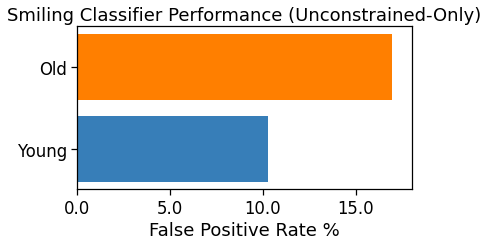

In [ ]:
#@title Calculate FPR and Compare Unconstrained Performance
young_fpr_unconstrained = calculate_fpr(unconstrained_results_young)
old_fpr_unconstrained = calculate_fpr(unconstrained_results_old)

title = 'Smiling Classifier Performance (Unconstrained-Only)'
plot_results([young_fpr_unconstrained, old_fpr_unconstrained], title)

A false positive is where the model incorrectly predicts the positive class. In this context, that means a false positive outcome occurs when the ground truth is an image of a celebrity 'Not Smiling' and the model predicts 'Smiling'. By extension, the false positive rate, which is used in the visualization above, is a measure of accuracy for a test.

Looking at performance across age group should reveal a **disproportionate gap between "Old" and "Young" categories**.

This is where TFCO can come in and help close that gap by constraining the false positive rate to be within a more acceptable criterion.


# Constrained Model Set Up

One of the main challenges when setting up a constrained problem in Keras is that Keras losses and metrics take only two parameters (the labels y_true, and the predictions y_pred). Often, however, the constraints depend on extra side information (in this case, the old/young protected group information).

To make sure that this side information is available to TFCO (which creates a
custom loss), we replace y_true with a *two-column* Tensor, with the first column containing the labels, and the second the protected group information. The `DatasetWrapper` iterator, which we create in the upcoming cell, performs this transformation:

In [ ]:
class DatasetWrapper(object):
  """An iterator wrapping input_function.

  Normally, input_function iterates over three quantities: the features, the
  labels, and the protected group information. Keras normally only looks at the
  first two, but this iterator will combine the labels and protected group
  information into one `Tensor`, with the labels in the first column and the
  protected group information in the second. 
  """

  def __init__(self, wrapped):
    self._wrapped = wrapped
    self._wrapped_iter = self._wrapped.__iter__()

  def __iter__(self):
    self._wrapped_iter = self._wrapped.__iter__()
    return self

  def __next__(self):
    features, label, group = self._wrapped_iter.__next__()
    combined = tf.stack([label, group], axis=1)
    return (features, combined)

Now that y_true contains two columns, we need to be able to *extract* the relevant information whenever needed. To this end, we create the following `tfco.KerasPlaceholders`, which tell us how to map the y_true and y_pred arguments to particular quantities of interest (the predictions, labels, and protected group information, respectively):


In [ ]:
# We use KerasPlaceholder objects to define how the inputs to the Keras loss
# function (y_true and y_pred) should be mapped to inputs into TFCO. Notice in
# particular that the labels are in the first column of y_true, and the group
# indicators are in the second column.
tfco_predictions = tfco.KerasPlaceholder(lambda _, y_pred: y_pred)
tfco_labels = tfco.KerasPlaceholder(lambda y_true, _: y_true[:, 0])
tfco_groups = tfco.KerasPlaceholder(lambda y_true, _: y_true[:, 1])
tfco_placeholders = [tfco_predictions, tfco_labels, tfco_groups]


As documented in [TFCO's library](https://github.com/google-research/tensorflow_constrained_optimization/tree/master/README.md), there are several helpers that will make it easier to constrain the problem:

1.   `tfco.rate_context()` – A "context" tells us what we're taking a rate *of*. Here, for example, we're interested in the error rate on the full dataset, and the FPRs on the "old" and "young" protected classes, so we construct contexts representing, respectively, the full dataset, and the "old"
and "young" protected classes.
1.   `tfco.error_rate()` and `tfco.false_positive_rate()`. These, among many other rate helpers, are used to specify what quantity you want to minimize, and what quantities you want to constrain.
1.   `tfco.KerasLayer()`– The rate expression to be minimized here will be the error rate, subject to FPR constraints. The `KerasLayer` is an identity function from the model's perspective, but contains TFCO state that is required for optimization (e.g. rate denominators, slack variables, and Lagrange multipliers), so it must be included somewhere in the model.

The cell below will call on these helpers to set up model training with the fairness constraint.

In [ ]:
# Create overall context and subsetted context. The subsetted contexts contain
# examples where group attribute < 0.5 and > 0.5 (i.e. "old" and "young"
# celebrity images), respectively.
tfco_context = tfco.rate_context(
    predictions=tfco_predictions, labels=tfco_labels)
tfco_old_context = tfco_context.subset(lambda: tfco_groups() < 0.5)
tfco_young_context = tfco_context.subset(lambda: tfco_groups() >= 0.5)

# Minimize overall error rate....
tfco_objective = tfco.error_rate(tfco_context)
# .... such that FPR on the both groups is at most 5%.
tfco_constraints = [
    tfco.false_positive_rate(tfco_old_context) <= 0.05,
    tfco.false_positive_rate(tfco_young_context) <= 0.05,
]
# Another possibility would be to constrain the "old" FPR to be no larger than
# the "young" FPR, which could be accomplished with the constraint set:
#   tfco_constraints = [
#       tfco.false_positive_rate(tfco_old_context) <=
#       tfco.false_positive_rate(tfco_young_context)
#   ]
# If you're interested, try this version out, instead!

# Setup rate minimization problem: minimize overall error rate s.t. constraints,
# and store everything needed in "tfco_layer", which will be included in the
# sequential Keras model, below.
tfco_layer = tfco.KerasLayer(
    objective=tfco_objective,
    constraints=tfco_constraints,
    placeholders=tfco_placeholders)

# Unlike in the "unconstrained" case, the KerasMetricWrapper must now also
# extract the labels from the y_true metric parameter, which contains two
# columns, the labels and protected class information. To this end, we pass the
# tfco_labels KerasPlaceholder to the metrics, so that it knows to take the
# first column.
constrained_metrics = [
    tfco.KerasMetricWrapper(
        tf.keras.metrics.BinaryAccuracy(),
        labels=tfco_labels,
        from_logits=True,
        name='accuracy'),
    tfco.KerasMetricWrapper(
        tf.keras.metrics.FalsePositives(),
        labels=tfco_labels,
        from_logits=True,
        name='fp'),
    tfco.KerasMetricWrapper(
        tf.keras.metrics.TrueNegatives(),
        labels=tfco_labels,
        from_logits=True,
        name='tn')
]

# Notice the presence of "tfco_layer". This is necessary, since it is this
# object that contains the extra state (slack variables, Lagrange multipliers,
# etc.) used by TFCO. From the perspective of the *model*, however, this layer
# does nothing--it's an identity function.
constrained_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=None), tfco_layer
])

constrained_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tfco_layer.loss,
    metrics=constrained_metrics)

The model is now set up and ready to be trained with the false positive rate constraint across age group. Notice the use of `DatasetWrapper`, which appends the protected group information as the second column of the labels.

In [ ]:
celeb_a_train_data = DatasetWrapper(input_function(
    tfds.Split.TRAIN, subgroup_filter='None'))
constrained_model.fit(celeb_a_train_data, epochs=10, steps_per_epoch=1000)

Epoch 1/10
1000/1000 [==============================] - 73s 73ms/step - loss: 0.4597 - accuracy: 0.8094 - fp: 5486.0000 - tn: 46501.0000
Epoch 2/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.3909 - accuracy: 0.8390 - fp: 3024.0000 - tn: 48973.0000
Epoch 3/10
1000/1000 [==============================] - 69s 69ms/step - loss: 0.3854 - accuracy: 0.8419 - fp: 2589.0000 - tn: 49600.0000
Epoch 4/10
1000/1000 [==============================] - 68s 68ms/step - loss: 0.3875 - accuracy: 0.8402 - fp: 2612.0000 - tn: 49359.0000
Epoch 5/10
1000/1000 [==============================] - 70s 70ms/step - loss: 0.3810 - accuracy: 0.8433 - fp: 2474.0000 - tn: 49510.0000
Epoch 6/10
1000/1000 [==============================] - 71s 71ms/step - loss: 0.3697 - accuracy: 0.8469 - fp: 2582.0000 - tn: 49497.0000
Epoch 7/10
1000/1000 [==============================] - 69s 69ms/step - loss: 0.3685 - accuracy: 0.8481 - fp: 2538.0000 - tn: 49410.0000
Epoch 8/10
1000/1000 [===================

In [ ]:
print('Overall Results, Constrained')
celeb_a_test_data = DatasetWrapper(input_function(
    tfds.Split.TEST, subgroup_filter='None'))
constrained_results = constrained_model.evaluate(celeb_a_test_data)

Overall Results, Constrained
201/201 [==============================] - 13s 66ms/step - loss: 0.3239 - accuracy: 0.8632 - fp: 516.0000 - tn: 9507.0000


As one should expect, the accuracy of the constrained model is slightly worse than the unconstrained model. But what's more important is improved performance across groups.

In [ ]:
print('Results for Young Group, Constrained')
celeb_a_test_young_group_data = DatasetWrapper(input_function(
    tfds.Split.TEST, batch_size=1, subgroup_filter='Young'))
constrained_results_young = constrained_model.evaluate(celeb_a_test_young_group_data)

Results for Young Group, Constrained
15115/15115 [==============================] - 41s 3ms/step - loss: 0.2967 - accuracy: 0.8754 - fp: 404.0000 - tn: 7213.0000


In [ ]:
print('Results for Old Group, Constrained')
celeb_a_test_old_group_data = DatasetWrapper(input_function(
    tfds.Split.TEST, batch_size=1, subgroup_filter='Old'))
constrained_results_old = constrained_model.evaluate(celeb_a_test_old_group_data)

Results for Old Group, Constrained
4849/4849 [==============================] - 24s 5ms/step - loss: 0.4073 - accuracy: 0.8261 - fp: 109.0000 - tn: 2250.0000


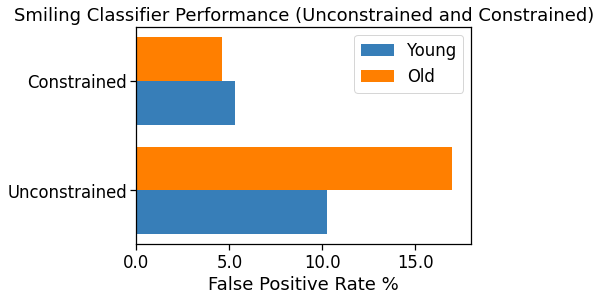

In [ ]:
#@title Calculate FPR and Compare Constrained Performance
young_fpr_constrained = calculate_fpr(constrained_results_young)
old_fpr_constrained = calculate_fpr(constrained_results_old)

title = 'Smiling Classifier Performance (Unconstrained and Constrained)'
fpr_results = [
    young_fpr_unconstrained, old_fpr_unconstrained, young_fpr_constrained,
    old_fpr_constrained
]
plot_results(fpr_results, title)

TFCO's ability to express a more complex requirements as rate constraints helped this model to achieve a more desirable outcome. There is still room for improvement, but at least TFCO was able to find a model that roughly satisfies the constraints, while significantly reducing the disparity between the FPRs of the two groups.

We've found that this particular training pipeline is a bit unstable: usually, if you run it, you will achieve results similar to the above, but occasionally, the constrained (or unconstrained) optimization will get stuck at a comparitively-poor local optimum. The simplest solution would be to train multiple times, and keep the best result. Another, more advanced, alternative, would be to use `tfco.find_best_candidate_index()` (or `tfco.find_best_candidate_distribution()`) helper, which can help choose the best iterate (or best distribution over iterates), out of the ones found after each epoch. Think of `tfco.find_best_candidate_index()` as an added heuristic that ranks each of the outcomes based on accuracy and fairness constraint (in this case, false positive rate across age group) separately with respect to the training data. That way, it can search for a better trade-off between overall accuracy and the fairness constraint.